# Modelització del consum elèctric d'un habitatge

### Per: *Pol Reviejo*, Data Scientist i Estadístic

En aquesta segona part del projecte es desenvolupen dos models predictius per tal de predir el consum que tindrà un habitatge. S'utilitzen dades diàries i d'alta freqüència a nivell hora, acabant sent aquest model el què té una millor capacitat predictiva al agregar els seus resultats a nivell diari.

________________________

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql as psql

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import lightgbm as lgb

_____________________________________

# Modelització Consum diari

Es tractarà de predir el consum diari de l'habitatge usant directament l'històric del consum diari observat desde 2023 fins a 2025. A partir de la sèrie temporal del dia es pot treure informació rellevant com el dia de la setmana, el mes, l'any o el consum dels dies anteriors.

Es carrega el dataset amb el consum elèctric diari.

In [2]:
df = pd.read_excel('Consum_diari.xlsx')
df = df.drop(columns=["Unnamed: 0"])
df

,Data,Dia,Mes,Any,kwd
0,2023-03-01,Wednesday,March,2023,3.211
1,2023-03-02,Thursday,March,2023,4.811
2,2023-03-03,Friday,March,2023,3.740
3,2023-03-04,Saturday,March,2023,5.901
4,2023-03-05,Sunday,March,2023,7.886
...,...,...,...,...,...
666,2025-01-01,Wednesday,January,2025,3.074
667,2025-01-02,Thursday,January,2025,4.823
668,2025-01-03,Friday,January,2025,4.114
669,2025-01-04,Saturday,January,2025,3.224


Recapitulant amb l'anàlisi es té la següent sèrie temporal del consum elèctric diari. S'observen pics de consum que venen donats pel dia de la setmana. En concret aquests pics de consum corresponen als Diumenges.

Per la resta es pot observar com el consum diari es manté estable setmanalment i mensualment a través de les mitjanes mòbils.

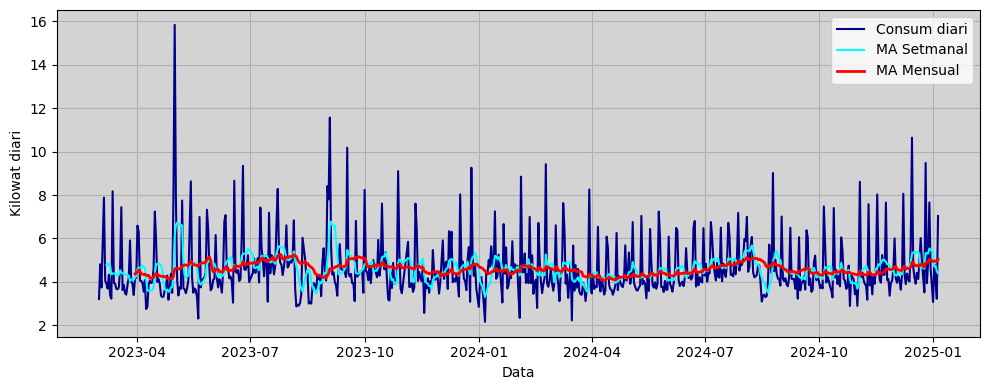

In [3]:
plt.figure(figsize=(10,4))

plt.plot(df["Data"],df["kwd"],color='darkblue',label="Consum diari")
plt.plot(df["Data"],df["kwd"].rolling(window=7).mean(),color='cyan',label="MA Setmanal")
plt.plot(df["Data"],df["kwd"].rolling(window=30).mean(),color='red',label="MA Mensual",linewidth=2)

plt.xlabel("Data")
plt.ylabel("Kilowat diari")
plt.grid(True)
plt.gca().set_facecolor("lightgray")  
plt.legend()
plt.tight_layout()
plt.show()

Per predir utilitzaré els lags del consum diari. És a dir, $kwd_{t-i},\forall i \in \{1,2,3,...,14\}$

D'alguna manera saber el consum elèctric que hi ha hagut uns dies abans podria ser rellevant per predir el consum elèctric que hi haurà en un dia.

In [4]:
for lag in range(1, 8):  # Crear lags de les últimes 24 hores
    df[f'lag_{lag}'] = df['kwd'].shift(lag)

Faig One Hot Encoding dels dies de la setmana i mes, que usaré per predir.

In [5]:
df2 = df.copy()
df2 = pd.get_dummies(df2, columns=['Dia'], drop_first=True, dtype=int)
df2 = pd.get_dummies(df2, columns=['Mes'], drop_first=True, dtype=int)

In [6]:
df2.columns

Index(['Data', 'Any', 'kwd', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'Dia_Monday', 'Dia_Saturday', 'Dia_Sunday',
       'Dia_Thursday', 'Dia_Tuesday', 'Dia_Wednesday', 'Mes_August',
       'Mes_December', 'Mes_February', 'Mes_January', 'Mes_July', 'Mes_June',
       'Mes_March', 'Mes_May', 'Mes_November', 'Mes_October', 'Mes_September'],
      dtype='object')

S'eliminen els casos missing per modelar. En aquest cas, son els casos que no tenen un lag informat. 

In [7]:
df2.dropna(inplace=True)

In [8]:
df2["set"] = None
df2.loc[ df2["Data"] > "2024-06-01", "set"] = "test"
df2.loc[ df2["Data"] <= "2024-06-01", "set"] = "train"

Es prepara el conjunt train i test per entrenar i validar el model. Entrenaré el model fins al 1 de Juny de 2024 i les dades posteriors a aquesta data seran utilitzades per validar el model.

In [9]:
df2["set"] = None
df2.loc[ df2["Data"] > "2024-06-01", "set"] = "test"
df2.loc[ df2["Data"] <= "2024-06-01", "set"] = "train"

In [10]:
X_train = df2.loc[
    df2["set"]=="train",
    ['Dia_Monday', 'Dia_Saturday', 'Dia_Sunday', 'Dia_Thursday', 'Dia_Tuesday','Dia_Wednesday',
    'Mes_August', 'Mes_December', 'Mes_February','Mes_January', 'Mes_July',
    'Mes_June', 'Mes_March', 'Mes_May','Mes_November', 'Mes_October', 'Mes_September',
    'Any','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','lag_6', 'lag_7']
]

X_test = df2.loc[
    df2["set"]=="test",
    ['Dia_Monday', 'Dia_Saturday', 'Dia_Sunday', 'Dia_Thursday', 'Dia_Tuesday','Dia_Wednesday',
    'Mes_August', 'Mes_December', 'Mes_February','Mes_January', 'Mes_July',
    'Mes_June', 'Mes_March', 'Mes_May','Mes_November', 'Mes_October', 'Mes_September',
    'Any','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','lag_6', 'lag_7']
]

y_train = df2.loc[df2["set"]=="train",["kwd"]]
y_test = df2.loc[df2["set"]=="test",["kwd"]]

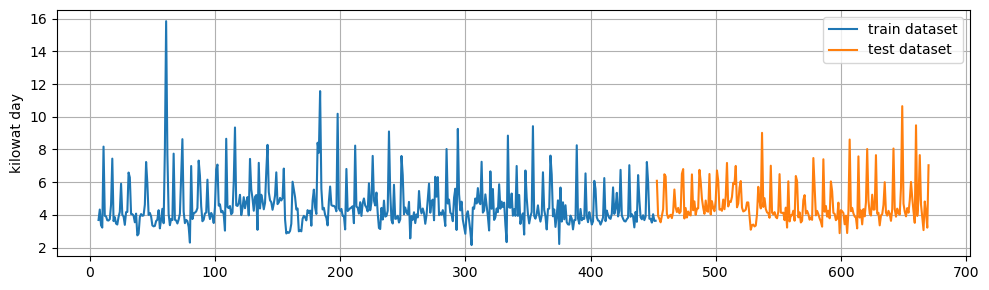

In [11]:
plt.figure(figsize=(10,3))
plt.plot(X_train.index,y_train,label="train dataset")
plt.plot(X_test.index,y_test,label="test dataset")
plt.ylabel("kilowat day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

S'estima un model Random Forest per predir el consum diari i es valida al conjunt test.

In [12]:
model_rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf1.fit(X_train, y_train)

y_pred = model_rf1.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Random Forest:",r2)

C:\Users\Pol\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2 Random Forest: 0.4194498665275347


Tal i com es pot veure al següent gràfic saber si el dia de la setmana és un Diumenge és molt rellevant per predir el consum elèctric.

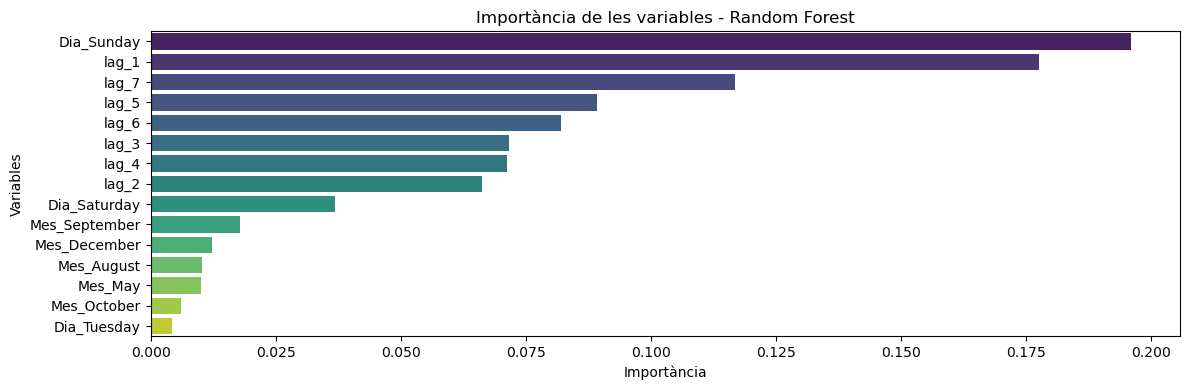

In [13]:
importances = model_rf1.feature_importances_
feature_names = X_train.columns

# Ordenar per importància
indices = np.argsort(importances)[::-1]  # De més a menys important
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# Crear el gràfic
plt.figure(figsize=(12, 4))
sns.barplot(x=sorted_importances[:15], y=sorted_features[:15], palette="viridis")  # Top 15 variables
plt.xlabel("Importància")
plt.ylabel("Variables")
plt.title("Importància de les variables - Random Forest")

plt.tight_layout()

plt.show()

Es comparen valors reals i predits. En verd es mostra la predicció del consum elèctric diari del model i en taronja el consum elèctric diari observat. Sembla que el model és capaç d'identificar alguns patrons com els pics de consum del Diumenge.

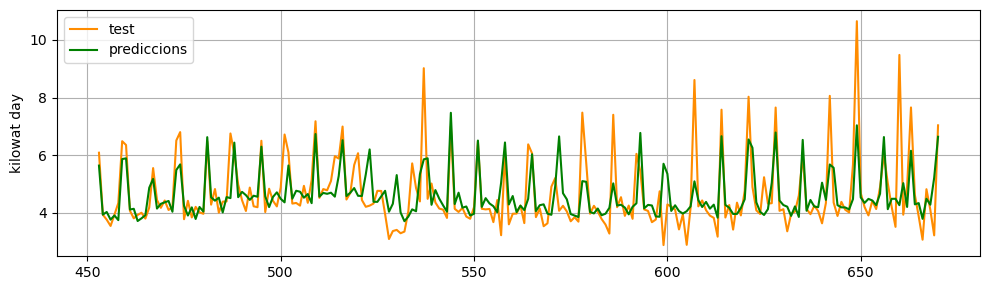

In [14]:
plt.figure(figsize=(10,3))
plt.plot(X_test.index,y_test,label="test",color='darkorange')
plt.plot(X_test.index,y_pred,label="prediccions",color='green')
plt.ylabel("kilowat day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Guardo prediccions del model diari.

In [15]:
X_test_full = df2[df2["set"]=="test"].copy()
X_test_full["kwh_pred"] = y_pred
kwd_model_dia = X_test_full[ ["Data","kwh_pred"] ]

___________________________________________

# Modelització Consum hora

Es tenen les dades a nivell hora també i es pot per tant fer un model que predigui el consum per cada hora.

Posteriorment es poden obtenir les prediccions a nivell dia sumant les prediccions dels 24 hores d'un dia, és a dir:

$$kw_d=\sum_{h=1}^{24}kwd_{d,h}$$

Si es prediu cada hora amb una certa precisió es podria crear un model que prediu el consum diari de forma molt bona.

Es preparen les dades a nivell hora:

In [16]:
df = pd.read_csv('Consum_historic.csv', delimiter=",", dtype=str)
df = df[ ["Data","Hora","AE_kWh"] ]

# Convertir 'Data' a datetime, especificant el format correcte
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
# Convertir 'AE_kWh' a float, substituint les comes per punts
df['AE_kWh'] = df['AE_kWh'].str.replace(',', '.').astype(float)
df["Hora"] = df["Hora"].astype(float)

# Afegir el dia de la setmana
df['Dia'] = df['Data'].dt.day_name()
# Afegir el mes
df['Mes'] = df['Data'].dt.month_name()
# Afegir l'any
df['Any'] = df['Data'].dt.year
# Afegir el mes en numeric
df["Mes_num"] = None
num=1
for mes in ["January","February","March","April","May","June","July","August","September","October","November","December"]:
    df.loc[ df["Mes"]==mes, ["Mes_num"]] = num
    num=num+1

# Crear la columna 'Datetime' sumant les hores a la data
df["Datetime"] = df["Data"] + pd.to_timedelta(df["Hora"].astype(int) - 1, unit="h")

# Ordeno les dades per la Datetime, ja que en el excel orginal no venen ordenades
df = df.sort_values(by='Datetime')
df.index = range(len(df))

One Hot Encoding del dia de la setmana, mes i any.

In [17]:
df2 = pd.get_dummies(df, columns=['Dia','Mes','Any'], drop_first=True, dtype=int)
df2.columns

Index(['Data', 'Hora', 'AE_kWh', 'Mes_num', 'Datetime', 'Dia_Monday',
       'Dia_Saturday', 'Dia_Sunday', 'Dia_Thursday', 'Dia_Tuesday',
       'Dia_Wednesday', 'Mes_August', 'Mes_December', 'Mes_February',
       'Mes_January', 'Mes_July', 'Mes_June', 'Mes_March', 'Mes_May',
       'Mes_November', 'Mes_October', 'Mes_September', 'Any_2024', 'Any_2025'],
      dtype='object')

Es genera el lag de fins les primeres 24 hores $t-24$ dels ```AE_kWh```

In [18]:
for lag in range(1, 25):  # Crear lags de les últimes 24 hores
    df2[f'lag_{lag}'] = df2['AE_kWh'].shift(lag)

Al generar lags, hi ha 24 casos que no tenen un lag i està en missing. Els elimino.

In [19]:
df2.dropna(inplace=True)

De nou s'entrenarà el model amb les dades fins al 1 de Juny i es validarà amb les dades posteriors a aquesta data.

In [20]:
df2["set"] = None
df2.loc[ df2["Data"] > "2024-06-01", "set"] = "test"
df2.loc[ df2["Data"] <= "2024-06-01", "set"] = "train"

Tractaré de fer un model més simple ja que s'està fent un model per el consum de cada hora el mes resulta menys rellevant i modelar amb lags de moltes hores enrere no és útil i generarà overfitting.

In [21]:
X_train = df2.loc[
    df2["set"]=="train",
    ['Hora',
     'Dia_Sunday',
    'lag_1', 'lag_2', 'lag_3', 'lag_4']
]

X_test = df2.loc[
    df2["set"]=="test",
    ['Hora',
    'Dia_Sunday',
    'lag_1', 'lag_2', 'lag_3', 'lag_4']
]

y_train = df2.loc[df2["set"]=="train",["AE_kWh"]]
y_test = df2.loc[df2["set"]=="test",["AE_kWh"]]

Es mostra la sèrie temporal d'entrenament del model en blau i de validació del model en taronja.

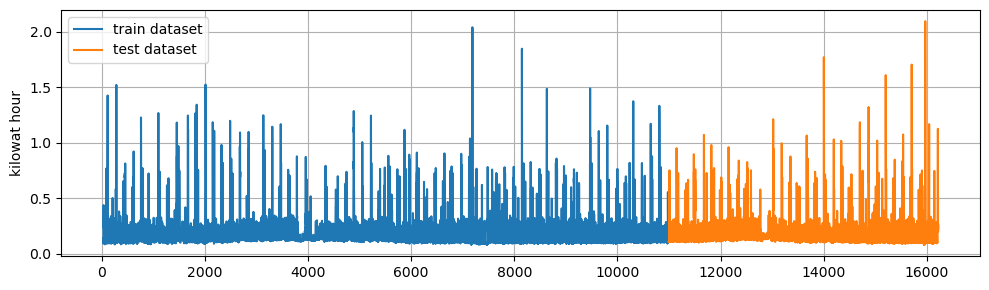

In [22]:
plt.figure(figsize=(10,3))
plt.plot(X_train.index,y_train,label="train dataset")
plt.plot(X_test.index,y_test,label="test dataset")
plt.ylabel("kilowat hour")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

S'estima el RandomForest i es veu l'ajust al conjunt test. Aquest $R^2$ és a nivell hora, posteriorment s'agregaran les prediccions i s'obtindrà l'$R^2$ a nivell dia. De totes maneres, mostra una major capacitat predictiva que el model a nivell dia.

In [23]:
model_rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf1.fit(X_train, y_train.values.ravel())

y_pred = model_rf1.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Random Forest:",r2)

R2 Random Forest: 0.5318764947241104


Es mostra l'importància de les variables. Sent el consum de l'hora anterior i l'Hora les variables més rellevants.

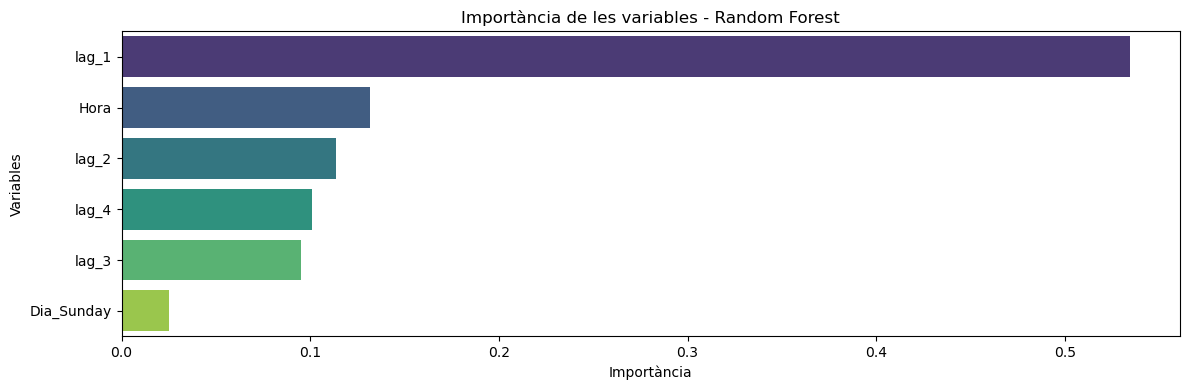

In [24]:
importances = model_rf1.feature_importances_
feature_names = X_train.columns

# Ordenar per importància
indices = np.argsort(importances)[::-1]  # De més a menys important
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# Crear el gràfic
plt.figure(figsize=(12, 4))
sns.barplot(x=sorted_importances[:15], y=sorted_features[:15], palette="viridis")  # Top 15 variables
plt.xlabel("Importància")
plt.ylabel("Variables")
plt.title("Importància de les variables - Random Forest")

plt.tight_layout()

plt.show()

Es mostra en taronja el consum real i en verd el consum predit per cada hora.

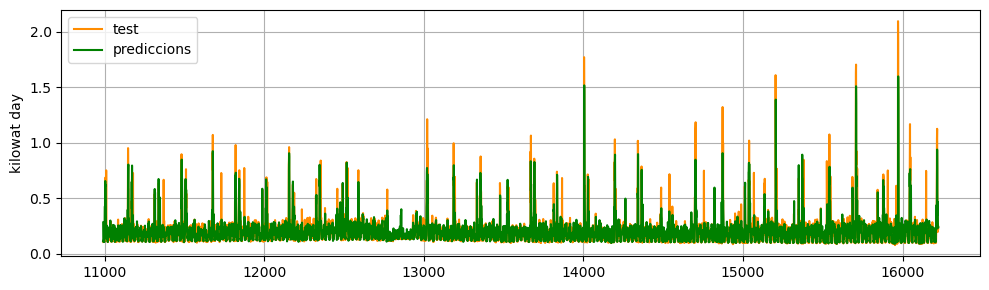

In [25]:
plt.figure(figsize=(10,3))
plt.plot(X_test.index,y_test,label="test",color='darkorange')
plt.plot(X_test.index,y_pred,label="prediccions",color='green')
plt.ylabel("kilowat day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Calculo els residus del model al dataset test. $$e_{d,h}=y_{d,h}-\hat{y}_{d,h}$$

In [26]:
X_test_full = df2[df2["set"]=="test"].copy()
X_test_full["kwh_pred"] = y_pred
X_test_full["res"] = X_test_full["AE_kWh"]-X_test_full["kwh_pred"]

Es pot veure com els residus es distribueixen majoritàriament entorn de 0, i sent tant positius com negatius.

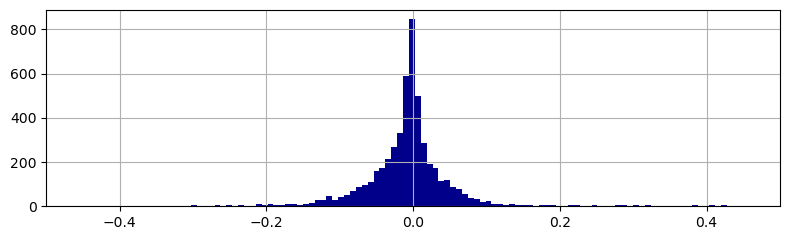

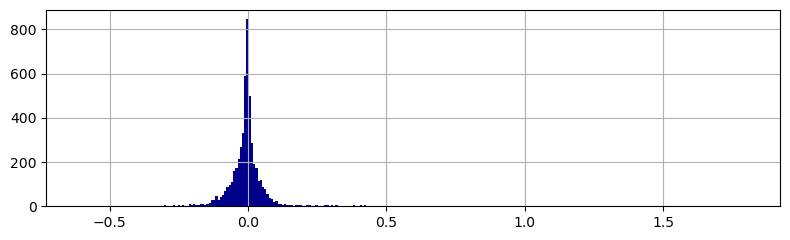

In [27]:
plt.figure(figsize=(8,2.5))
plt.hist(x = X_test_full["res"], bins=300,color='darkblue')
plt.xlim(-0.5,0.5)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(8,2.5))
plt.hist(x = X_test_full["res"], bins=300,color='darkblue')
plt.grid(True)
plt.tight_layout()

plt.show()

Es mostra el valor observat a l'eix horitzontal i el predit a l'eix vertical. De forma prou correcte es veu com el valo0r predit s'assembla al valor real ja que es concentren entorn la recta, és a dir: $y_{d,h}\approx\hat{y}_{d,h}$

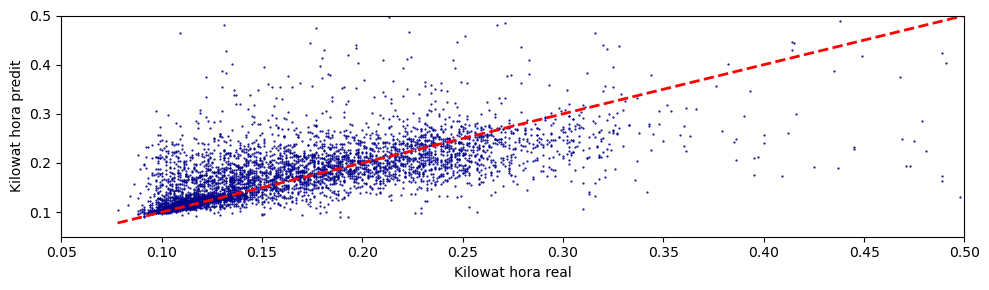

In [28]:
plt.figure(figsize=(10,3))

plt.scatter(x=X_test_full["AE_kWh"],y=X_test_full["kwh_pred"],s=0.3,color='darkblue')

plt.xlabel("Kilowat hora real")
plt.ylabel("Kilowat hora predit")

x_vals = np.linspace(min(X_test_full['AE_kWh']), max(X_test_full['AE_kWh']), 100)
plt.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2)  # Dashed red line

plt.xlim(0.05,0.5)
plt.ylim(0.05,0.5)

plt.tight_layout()

plt.show()

Es grafica la sèrie temporal dels residus i es pinta una mitjana mòbil de 24 hores. Es pot veure com els residus es distribueixen de forma força igual, independentment del temps. La mitjana mòbil es manté estable entorn de 0.

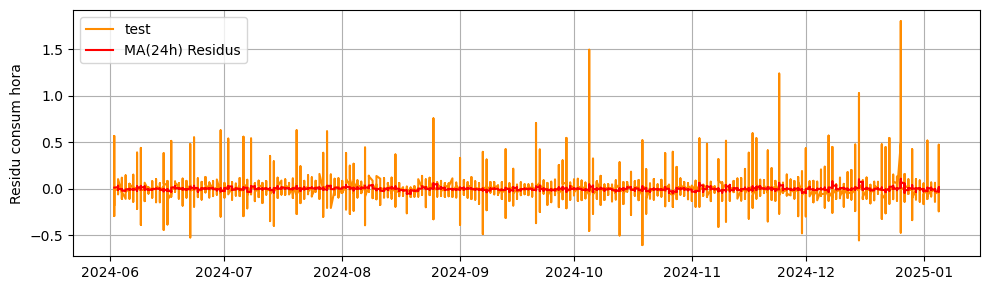

In [29]:
plt.figure(figsize=(10,3))
plt.plot(X_test_full["Data"],X_test_full["res"],label="test",color='darkorange')
plt.plot(X_test_full["Data"],X_test_full["res"].rolling(window=24).mean(),label="MA(24h) Residus",color='red')
plt.grid(True)
plt.ylabel("Residu consum hora")
plt.legend()
plt.tight_layout()
plt.show()

Aquestes prediccions a del kilowat hora les convertiré a prediccions del kilowat dia, simplement utilitzant:

$$kw_{dia}=\sum_{hora=1}^{24}kw_{dia,hora}$$

In [30]:
kwd_model_hora = X_test_full.groupby("Data", as_index=False)["kwh_pred"].sum()
kwd_model_hora.columns = ["Data","kwd_model_kwh"]

____________________

# Resultats finals

S'ajunta en un mateix dataset la predicció dels 2 models i el valor real observat del consum diari del conjunt test.

In [31]:
preds_2models = kwd_model_dia.merge(kwd_model_hora,how='left',left_on='Data',right_on='Data')

kwd_real = pd.read_excel('Consum_diari.xlsx')
kwd_real = kwd_real.drop(columns=["Unnamed: 0"])
kwd_real = kwd_real.loc[ kwd_real["Data"] > "2024-06-01", ["Data","kwd"] ]

preds_2models = preds_2models.merge(kwd_real,how='left',left_on='Data',right_on='Data')

Es mostra les prediccions dels 2 models i el valor observat. En vermell les prediccions del model que usa dades de cada hora, en verd el model que usa dades diaries i en blau el valor real del conjunt de validació test.

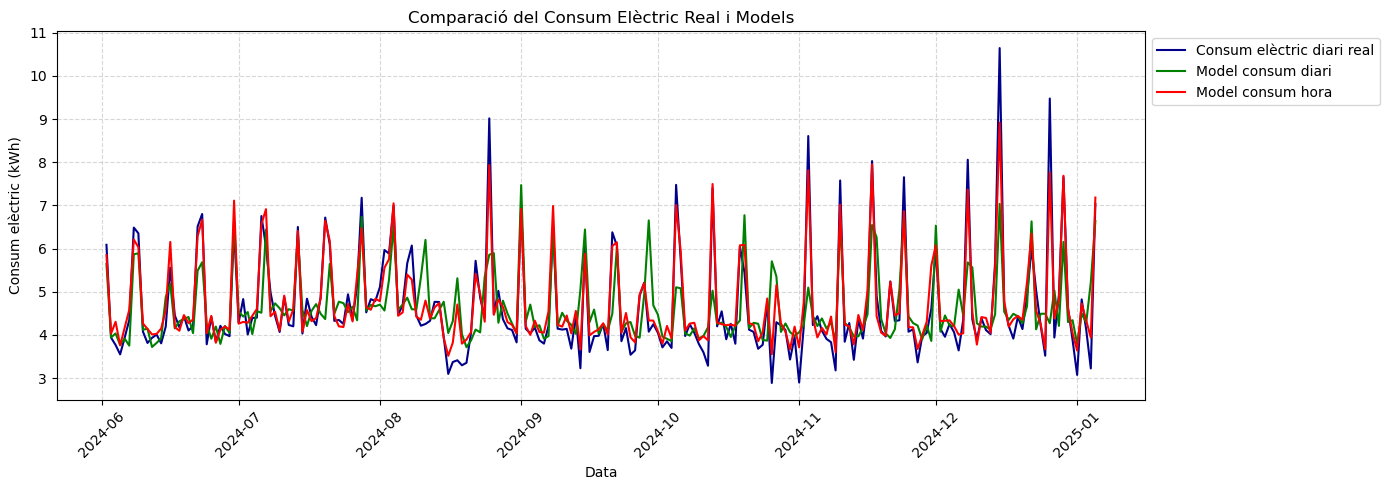

In [32]:
plt.figure(figsize=(14,5))
plt.plot(preds_2models["Data"], preds_2models["kwd"], label="Consum elèctric diari real", color='darkblue', linewidth=1.5)
plt.plot(preds_2models["Data"], preds_2models["kwh_pred"], label="Model consum diari", color='green', linewidth=1.5)
plt.plot(preds_2models["Data"], preds_2models["kwd_model_kwh"], label="Model consum hora", color='red', linewidth=1.5)

plt.xlabel("Data")
plt.ylabel("Consum elèctric (kWh)")
plt.title("Comparació del Consum Elèctric Real i Models")

plt.xticks(rotation=45)  
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Es pot veure en el primer gràfic com el model del consum hora té una major capacitat predictiva que el model de consum diari. El valor predit i observat son casi iguals, i el comportament de les 2 sèries temporals vermella i blava també.

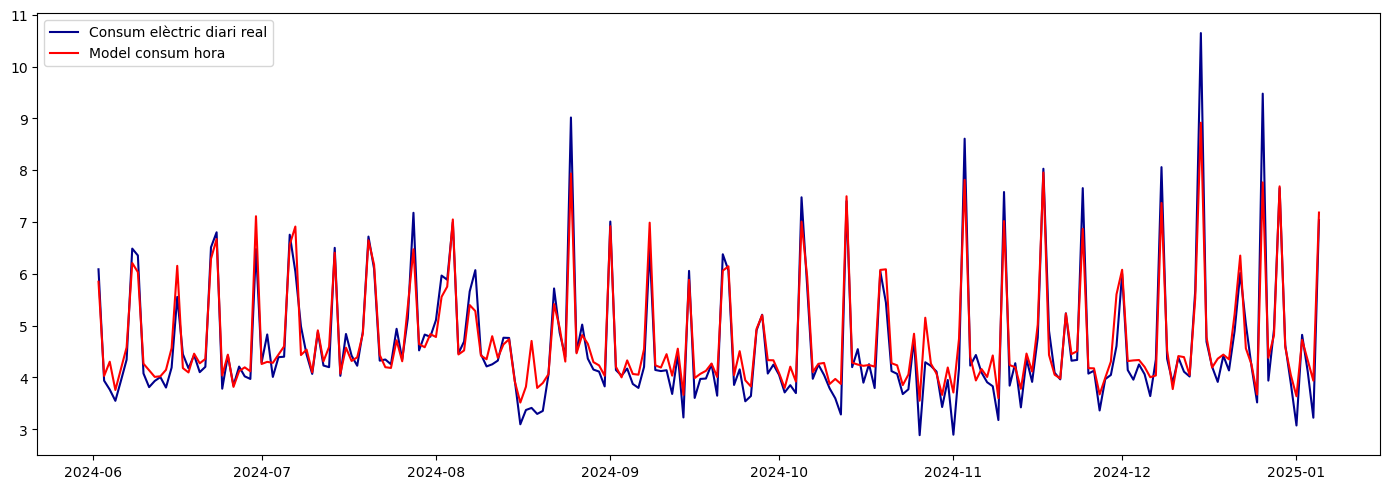

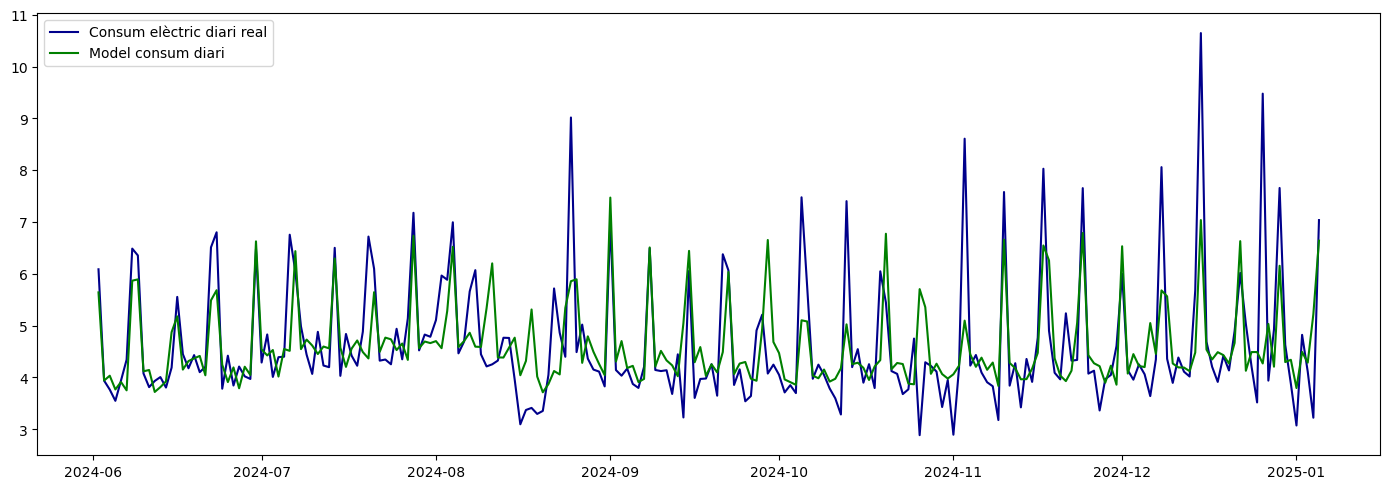

In [33]:
plt.figure(figsize=(14,5))
plt.plot(preds_2models["Data"], preds_2models["kwd"], label="Consum elèctric diari real", color='darkblue', linewidth=1.5)
plt.plot(preds_2models["Data"], preds_2models["kwd_model_kwh"], label="Model consum hora", color='red', linewidth=1.5)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(preds_2models["Data"], preds_2models["kwd"], label="Consum elèctric diari real", color='darkblue', linewidth=1.5)
plt.plot(preds_2models["Data"], preds_2models["kwh_pred"], label="Model consum diari", color='green', linewidth=1.5)
plt.legend()
plt.tight_layout()
plt.show()

El model amb dades de cada hora mostra una molt bona capacitat predictiva, amb un $R^2$ del $91\%$ mentre que l'altre model amb dades de cada dia experimenta més limitacions.

In [34]:
print( "R2 model consum diari:", r2_score(preds_2models["kwd"],preds_2models["kwh_pred"]) )
print( "R2 model consum hora:", r2_score(preds_2models["kwd"],preds_2models["kwd_model_kwh"]) )

R2 model consum diari: 0.4194498665275347
R2 model consum hora: 0.9108375068401333


**Conclusions:** Es pot veure com fer un model a nivell hora i posteriorment agregar les prediccions dona una capacitat predictiva molt superior a un model fet a nivell dia. Disposar de més informació i més detallada permet fer una predicció del consum diari molt millor.